# Task 4: Extra Model

In [28]:
import os
import pandas as pd
import nlp
import random
import string
import shutil
import nltk
import re
import pathlib
import spacy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


import keras

from collections import Counter
from nltk.corpus import stopwords
from tensorflow.keras import layers
from tensorflow.keras import losses
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier


In [29]:
# Always clear as keras backend is tedious
tf.keras.backend.clear_session()

In [30]:
#gpu setup when using Tensorflow to address memory expansion/growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [31]:
working_path = pathlib.Path().resolve()
path_object = pathlib.Path(working_path)
parent_path = path_object.parent
data_path  = os.path.join(parent_path, "01-Data/PubMed_200k_RCT_numbers_replaced_with_at_sign/")

In [32]:
ps = PorterStemmer()
lm = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
STOPWORDS = set(stopwords.words('english'))

def stem_words(text):
    return " ".join([ps.stem(word) for word in text.split()])
def lemmatize_words(text):
    return " ".join([lm.lemmatize(word) for word in text.split()])
def remove_punctuation(text,punctuation_string):
    return text.translate(str.maketrans('', '', punctuation_string))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])                                 
def remove_freqwords(text,freqwords):
    return " ".join([word for word in str(text).split() if word not in freqwords])
def remove_rarewords(text,rarewords):
    return " ".join([word for word in str(text).split() if word not in rarewords])
maxlen=50
def get_sequences(df,maxlen=50):
    #sequences = tokenizer.texts_to_sequences(df.text.tolist())
    padded = pad_sequences(sequences, truncating = 'post', padding='post', maxlen=maxlen)
    return padded
def get_lines(filename):
    with open(filename, "r") as f:    
        return f.readlines()

[nltk_data] Downloading package stopwords to /home/flavia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/flavia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/flavia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [33]:
def prepare_text(filename):
    """Returns a pandas dataframe.
    
    Reads filenames, its contents, seperates labels and text

    Args:
        filename

    Returns:
        pd.dataframe

    """
    input_lines = get_lines(filename)
    abstract_lines = "" 
    abstract_dict_list = [] 

    for line in input_lines:
        if line.startswith("###"): # check if new ID
            abstract_lines = "" #simple reset
        elif line.isspace(): # if new line?
            splitted_abstract_lines = abstract_lines.splitlines() # split abstract into separate lines
            for split_line in splitted_abstract_lines:
                abstract_dict = {} # create dict for easy df transfer
                split = split_line.split("\t") # split label from text with \t
                abstract_dict["label"] = split[0] # get label
                abstract_dict["text"]=split[1].lower()
                abstract_dict_list.append(abstract_dict)
        else: 
            abstract_lines += line
    df = pd.DataFrame(abstract_dict_list)

    #Remove punctuation
    punctuation_string = string.punctuation
    #punctuation_string = punctuation_string.replace('%', '')
    df["text_wo_punct"] = df["text"].apply(lambda text: remove_punctuation(text,punctuation_string))
    
    #Remove stopwords
    df["text_wo_stop"] = df["text_wo_punct"].apply(lambda text: remove_stopwords(text))
    
    #Remove most frequent words
    cnt = Counter()
    for text in df["text_wo_stop"].values:
        for word in text.split():
            cnt[word] += 1
    freqwords = set([w for (w, wc) in cnt.most_common(10)])
    df["text_wo_stopfreq"] = df["text_wo_stop"].apply(lambda text: remove_freqwords(text,freqwords))

    
    #Remove rarest words
    n_rare_words = 10
    rarewords = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
    df["text_wo_stopfreqrare"] = df["text_wo_stopfreq"].apply(lambda text: remove_rarewords(text,rarewords))

    #Stemming
    #df["text_stemmed"] = df["text_wo_stopfreqrare"].apply(lambda text: stem_words(text))
    #df["processed_text"] = df["text_wo_stopfreqrare"].apply(lambda text: stem_words(text))

    df["processed_text"] = df["text_wo_stopfreqrare"]
    
    return df

In [34]:
# Dataframes from preprocessing
df_train = prepare_text(data_path + "train.txt")
df_val   = prepare_text(data_path + "dev.txt")
df_test  = prepare_text(data_path + "test.txt")

In [35]:
#Helper dicts with relationships and inverse relationships
classes = set(df_train.label.tolist())
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items())
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [36]:
df_train = df_train.append(df_val)

/tmp/ipykernel_12470/1757480643.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append(df_val)


In [37]:
X_train = df_train["processed_text"]
#X_val = df_val["processed_text"]
X_test = df_test["processed_text"]

In [38]:
vectorizer = TfidfVectorizer(ngram_range=(2,2), max_features=10000) #use bigrams

total = X_train.append(X_test)

vectorizer = vectorizer.fit(total)

X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

/tmp/ipykernel_12470/2956661848.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total = X_train.append(X_test)


In [39]:
#to single digit label
Y_train = names_to_ids(df_train.label.tolist())
#Y_val   = names_to_ids(df_val.label.tolist())
Y_test  = names_to_ids(df_test.label.tolist())

In [41]:
model = RandomForestClassifier(n_estimators=150, n_jobs=14, random_state=42, min_samples_leaf=2, max_depth=7500, class_weight="balanced")

model.fit(X_train_tfidf, Y_train)

RandomForestClassifier(class_weight='balanced', max_depth=7500,
                       min_samples_leaf=2, n_estimators=150, n_jobs=14,
                       random_state=42)

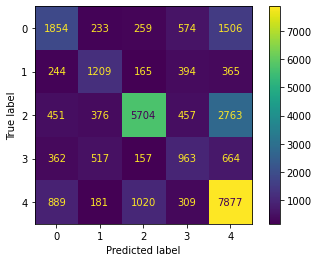

In [42]:
pred_vals = model.predict(X_test_tfidf)
#pred_vals = np.argmax(pred_vals, axis=1)
confma = confusion_matrix(Y_test, pred_vals, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=confma)
disp.plot()

In [43]:
f1 = f1_score(Y_test, pred_vals, average="weighted")

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_vals)

print("Test accuracy score : %s "% acc)

Test f1 score : 0.5951207325246439 
Test accuracy score : 0.5969891160614383 


Scores for regular 200k dataset
Test f1 score : 0.5838568204668012 
Test accuracy score : 0.5852914250839182 


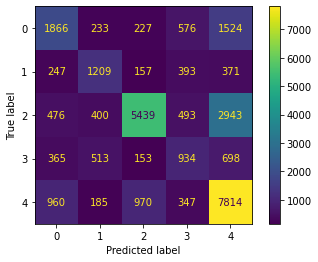

In [45]:
# 200k data

print("Scores for regular 200k dataset")

df200k_test  = prepare_text("../01-Data/PubMed_200k_RCT/" + "test.txt")
X200k_test = df200k_test["processed_text"]
X200k_test = vectorizer.transform(X200k_test)
Y200k_test  = names_to_ids(df200k_test.label.tolist())

pred_vals_200k = model.predict(X200k_test)
#pred_vals_200k = np.argmax(pred_vals_200k, axis=1)

confma = confusion_matrix(Y200k_test, pred_vals_200k, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=confma)
disp.plot()

f1 = f1_score(Y200k_test, pred_vals_200k, average="weighted")

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y200k_test, pred_vals_200k)

print("Test accuracy score : %s "% acc)

In [ ]:
model.save_weights('../04-Models/tfidf_randforest_model_1.tf')

print("saved")